# Question-Answer Pair Generation Using Large Language Models

## Overview
This notebook presents an innovative approach for generating high-quality question-answer pairs. Leveraging a Large Language Model (LLM), we aim to create a dataset that can be used for a variety of applications, particularly in fields requiring precise and accurate information retrieval, such as in medical contexts.

## Process Outline
Our approach is divided into four key steps:

### 1. Source Document Filtering
- **Objective**: To streamline the selection of relevant source material from a vast array of documents.
- **Method**: Implement a filtering mechanism that narrows down the number of source documents and selects pertinent paragraphs for subsequent processing.

### 2. Question Generation
- **Objective**: To formulate high-quality question candidates.
- **Method**: Utilize the capabilities of a Large Language Model, employing advanced prompt engineering techniques. Questions are designed to elicit responses that can either be direct extracts from selected source documents (PDFs) or concise, fact-based answers.

### 3. Automated Filtering of Q&A Pairs
- **Objective**: To refine the generated question-answer pairs and ensure their relevance and quality.
- **Methods**:
  - **N-gram Similarity**: Assess the similarity between the question and its context to filter out unrelated pairs.
  - **LLM Scoring**: Use a score provided by the LLM for the relatedness between the question and context.
  - **Text Embedding Vectors**: Create embeddings for questions to identify and remove highly similar questions.


In [1]:
!pip install langchain
!pip install openai
!pip install seaborn
!pip install matplotlib
!pip install pandas
!pip install scikit-learn
!pip install nltk
!pip install tiktoken
!pip install tqdm
!pip install rouge
!pip install flair
!pip install quantulum3
!pip install pyap

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load data

In [4]:
import pandas as pd

fname = "test_fold_one"
#fname = "test_fold_two"
#fname = "train_fold_one"
#fname = "train_fold_two"


df = pd.read_csv(f"../scripts/folds/data_folds/{fname}.csv")

df['Document'] = df.apply(lambda row: ': '.join(row.astype(str)), axis=1)
df.head()

,filename,header,section_text,Document
0,"MFR, dynamische scan op de D-SPECT, 1 daags",Vragen,Hebt u na het lezen van deze informatie nog vr...,"MFR, dynamische scan op de D-SPECT, 1 daags: V..."
1,Borstoperatie met prothese,Vragen,Heeft u naar aanleiding van deze folder vragen...,Borstoperatie met prothese: Vragen: Heeft u na...
2,Afdeling 3 zuid (ZGT Almelo),Wat is het telefoonnummer?,Het telefoonnummer van onze afdeling is: 088 7...,Afdeling 3 zuid (ZGT Almelo): Wat is het telef...
3,Basaalcelcarcinoom,Contact,Bij vragen of problemen kunt u tijdens kantoor...,Basaalcelcarcinoom: Contact: Bij vragen of pro...
4,ERCP,Wanneer contact opnemen met het,ziekenhuis? Complicaties komen bij dit onderzo...,ERCP: Wanneer contact opnemen met het: ziekenh...


## Source Document Filtering

## Question Generation

In [5]:
from qa_generation import QAGenerator
from prompt_factory import PromptFactory
from tqdm.notebook import tqdm

template = '''
        Gedraag je als een {role} die online informatie zoekt.
        Patiënten stellen meestal vragen als:
{{
    "qa_list": [
        {{
            "question": "Hoe kan ik een verstopte voedingssonde doorspoelen?",
            "answer": "Om een verstopte voedingssonde door te spoelen, kunt u de volgende stappen proberen: 1. Sluit de spuit rechtstreeks aan op de sonde (niet op het voedingssysteem). Als er een verstopping is in het voedingssysteem, kunt u dit vervangen. 2. Neem een spuit van 10 cc en spuit met lichte druk lauwwarm water door de voedingssonde. Herhaal dit zo nodig nog een keer. 3. Als het oplossen van de verstopping niet lukt, laat dan lauwwarm water 30 minuten inwerken en herhaal de bovenstaande procedure nogmaals. 4. Als u de verstopping kunt zien, kunt u proberen om de voedingssonde op die plek zachtjes te kneden. Als de verstopping dan loskomt, kunt u het doorspuiten met lauwwarm water. Belangrijk: Gebruik nooit een voerdraad of koolzuurhoudend bronwater of frisdranken, omdat dit kan leiden tot perforatie. Daarnaast wordt het afraden om natriumbicarbonaat te gebruiken als medicatie de oorzaak is van de verstopping, omdat dit de verstopping groter kan maken."
        }}
    ]
}}


        in het json formaat: 
        {format}

Document Informatie:
        {document}

        Belangrijke Opmerking: Bij het genereren van vragen, gebruik specifieke termen en benamingen uit het document in plaats van algemene termen zoals 'dit onderzoek' of 'die procedure'. Verwijs direct naar de procedure of het document met de exacte naam om nauwkeurigheid en duidelijkheid in de vragen te waarborgen. Vermijd algemeenheden en zorg ervoor dat elke vraag direct gerelateerd is aan de verstrekte documentinformatie.


        Stel {n} vragen die beantwoord kunnen worden op basis van deze paragraaf in het formaat:
        {format}

        Zorg ervoor dat elke vraag en antwoord paar in een geldig JSON-formaat is. Dit betekent dat vragen en antwoorden tussen dubbele aanhalingstekens moeten staan, en de algemene structuur moet overeenkomen met het vereiste JSON-schema.
        '''

roles = [
    'Patiënt',
    'Nieuwe Ouder',
    'Oudere Patiënt',
    'Persoon die een Tweede Mening Zoekt',
    'Reiziger die Medisch Advies Na Reizen Zoekt',
    'Zorgverlener die Informatie Zoekt']

prompt_factory = PromptFactory(prompt=template,roles=roles)

num_questions_per_doc = 5 

QAGenerator = QAGenerator()
# Generate the data
data = []
import pandas as pd
from tqdm import tqdm

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    doc = row["Document"]
    # Do something with col1 and col2
    try:
        qa_list = QAGenerator.generate_qas(prompt_factory.generate_prompt(doc, num_questions_per_doc))
        for qa in qa_list:
            new_row = row.to_dict()
            new_row['Question'] = qa.question
            new_row['Answer'] = qa.answer
            data.append(new_row)
            
    except Exception as e:
            print(f"Failed to generate QA for doc: {doc[:100]}. Error: {e}")
            continue

# Convert to DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df.head()


100%|██████████| 20/20 [01:35<00:00,  4.77s/it]


,filename,header,section_text,Document,Question,Answer
0,"MFR, dynamische scan op de D-SPECT, 1 daags",Vragen,Hebt u na het lezen van deze informatie nog vr...,"MFR, dynamische scan op de D-SPECT, 1 daags: V...",Waar kan ik terecht met vragen over het MFR on...,U kunt bellen met de afdeling nucleaire genees...
1,"MFR, dynamische scan op de D-SPECT, 1 daags",Vragen,Hebt u na het lezen van deze informatie nog vr...,"MFR, dynamische scan op de D-SPECT, 1 daags: V...",Welk routenummer moet ik volgen om naar de afd...,U kunt routenummer 1.15 volgen om de afdeling ...
2,"MFR, dynamische scan op de D-SPECT, 1 daags",Vragen,Hebt u na het lezen van deze informatie nog vr...,"MFR, dynamische scan op de D-SPECT, 1 daags: V...",Wat is het telefoonnummer van de afdeling nucl...,U kunt bellen naar telefoonnummer 088 708 56 7...
3,"MFR, dynamische scan op de D-SPECT, 1 daags",Vragen,Hebt u na het lezen van deze informatie nog vr...,"MFR, dynamische scan op de D-SPECT, 1 daags: V...",Welke ziekenhuislocatie is de afdeling nucleai...,De afdeling nucleaire geneeskunde is gevestigd...
4,"MFR, dynamische scan op de D-SPECT, 1 daags",Vragen,Hebt u na het lezen van deze informatie nog vr...,"MFR, dynamische scan op de D-SPECT, 1 daags: V...",Tot wie kan ik mij wenden voor vragen over het...,U kunt terecht bij de afdeling nucleaire genee...


## Basic Statistics and Visualization of ngramsimilarity Similarity Scores

In [6]:
# Define the threshold
threshold = 0.05

# Filter the DataFrame
#df = df[df['Answer-Context N-gram Similarity'] >= threshold]

In [7]:
from answer_context_filter import calculate_bleu_score, calculate_rouge_score

# Calculate BLEU and ROUGE scores
df['Question-Context BLEU'] = df.apply(lambda row: calculate_bleu_score(row['Document'], row['Question']), axis=1)
df['Answer-Context BLEU'] = df.apply(lambda row: calculate_bleu_score(row['Document'], row['Answer']), axis=1)
df['Question-Context ROUGE'] = df.apply(lambda row: calculate_rouge_score(row['Document'], row['Question']), axis=1)
df['Answer-Context ROUGE'] = df.apply(lambda row: calculate_rouge_score(row['Document'], row['Answer']), axis=1)
df['Question-Context ROUGE-L F1'] = df['Question-Context ROUGE'].apply(lambda x: x[0]['rouge-l']['f'] if x else None)
df['Answer-Context ROUGE-L F1'] = df['Answer-Context ROUGE'].apply(lambda x: x[0]['rouge-l']['f'] if x else None)
# Display the updated DataFrame
df.head()


/home/jovyan/.local/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/jovyan/.local/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/jovyan/.local/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunc

,filename,header,section_text,Document,Question,Answer,Question-Context BLEU,Answer-Context BLEU,Question-Context ROUGE,Answer-Context ROUGE,Question-Context ROUGE-L F1,Answer-Context ROUGE-L F1
0,"MFR, dynamische scan op de D-SPECT, 1 daags",Vragen,Hebt u na het lezen van deze informatie nog vr...,"MFR, dynamische scan op de D-SPECT, 1 daags: V...",Waar kan ik terecht met vragen over het MFR on...,U kunt bellen met de afdeling nucleaire genees...,2.160402e-233,4.264035e-02,"[{'rouge-1': {'r': 0.046511627906976744, 'p': ...","[{'rouge-1': {'r': 0.3023255813953488, 'p': 0....",0.075472,0.456140
1,"MFR, dynamische scan op de D-SPECT, 1 daags",Vragen,Hebt u na het lezen van deze informatie nog vr...,"MFR, dynamische scan op de D-SPECT, 1 daags: V...",Welk routenummer moet ik volgen om naar de afd...,U kunt routenummer 1.15 volgen om de afdeling ...,8.713939e-03,1.505700e-156,"[{'rouge-1': {'r': 0.09302325581395349, 'p': 0...","[{'rouge-1': {'r': 0.13953488372093023, 'p': 0...",0.142857,0.222222
2,"MFR, dynamische scan op de D-SPECT, 1 daags",Vragen,Hebt u na het lezen van deze informatie nog vr...,"MFR, dynamische scan op de D-SPECT, 1 daags: V...",Wat is het telefoonnummer van de afdeling nucl...,U kunt bellen naar telefoonnummer 088 708 56 7...,2.748025e-03,2.370369e-02,"[{'rouge-1': {'r': 0.13953488372093023, 'p': 0...","[{'rouge-1': {'r': 0.23255813953488372, 'p': 0...",0.192308,0.344828
3,"MFR, dynamische scan op de D-SPECT, 1 daags",Vragen,Hebt u na het lezen van deze informatie nog vr...,"MFR, dynamische scan op de D-SPECT, 1 daags: V...",Welke ziekenhuislocatie is de afdeling nucleai...,De afdeling nucleaire geneeskunde is gevestigd...,1.523694e-03,5.866322e-80,"[{'rouge-1': {'r': 0.09302325581395349, 'p': 0...","[{'rouge-1': {'r': 0.11627906976744186, 'p': 0...",0.156863,0.192308
4,"MFR, dynamische scan op de D-SPECT, 1 daags",Vragen,Hebt u na het lezen van deze informatie nog vr...,"MFR, dynamische scan op de D-SPECT, 1 daags: V...",Tot wie kan ik mij wenden voor vragen over het...,U kunt terecht bij de afdeling nucleaire genee...,4.598516e-233,5.146152e-02,"[{'rouge-1': {'r': 0.046511627906976744, 'p': ...","[{'rouge-1': {'r': 0.27906976744186046, 'p': 0...",0.072727,0.413793


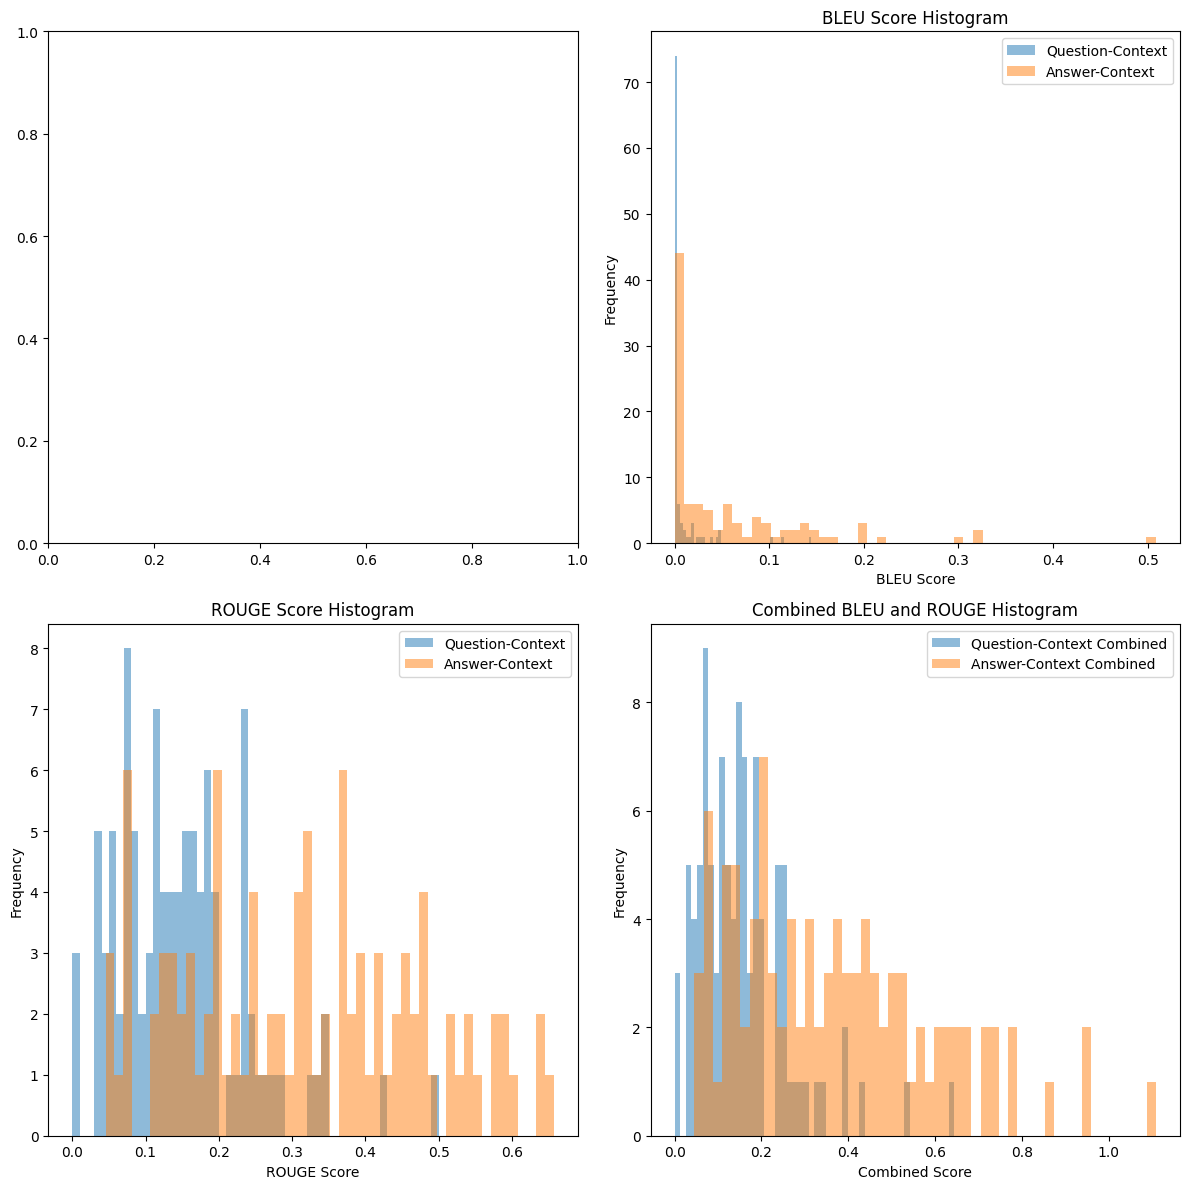

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 12))


# BLEU Score Histograms
axs[0, 1].hist(df['Question-Context BLEU'], bins=50, alpha=0.5, label='Question-Context')
axs[0, 1].hist(df['Answer-Context BLEU'], bins=50, alpha=0.5, label='Answer-Context')
axs[0, 1].set_title('BLEU Score Histogram')
axs[0, 1].set_xlabel('BLEU Score')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].legend()

# ROUGE Score Histograms
axs[1, 0].hist(df['Question-Context ROUGE-L F1'], bins=50, alpha=0.5, label='Question-Context')
axs[1, 0].hist(df['Answer-Context ROUGE-L F1'], bins=50, alpha=0.5, label='Answer-Context')
axs[1, 0].set_title('ROUGE Score Histogram')
axs[1, 0].set_xlabel('ROUGE Score')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].legend()

# Combined Metrics Histogram
combined_question = df['Question-Context BLEU'] + df['Question-Context ROUGE-L F1']
combined_answer = df['Answer-Context BLEU'] + df['Answer-Context ROUGE-L F1']
axs[1, 1].hist(combined_question, bins=50, alpha=0.5, label='Question-Context Combined')
axs[1, 1].hist(combined_answer, bins=50, alpha=0.5, label='Answer-Context Combined')
axs[1, 1].set_title('Combined BLEU and ROUGE Histogram')
axs[1, 1].set_xlabel('Combined Score')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


In [9]:
df = df[df['Answer-Context ROUGE-L F1'] > 0.1]

## Vector filter

In [10]:
from vector_filter import precompute_embeddings

embeddings = precompute_embeddings(df, 'Question')


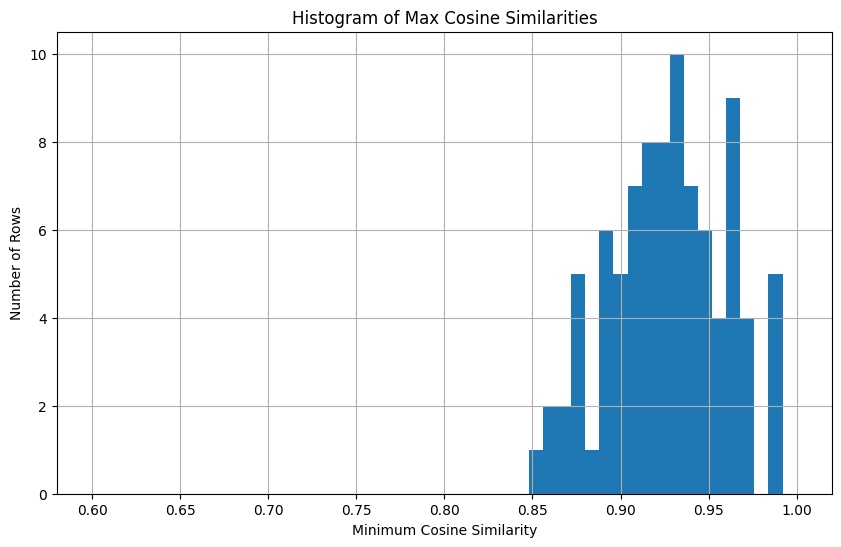

[0.9691124867765225, 0.9178462916790846, 0.9287400627978541, 0.9283298875874983, 0.9691124867765225, 0.963480531585351, 0.9866088589617679, 0.963480531585351, 0.9050169645569184, 0.9866088589617679, 0.9211015389142594, 0.8867387124560372, 0.911423184055389, 0.9280200674577164, 0.9635609180669698, 0.9069463426365476, 0.9887890540464485, 0.9280200674577164, 0.9198389727966385, 0.9198389727966385, 0.8929961005708431, 0.9353236022042473, 0.9024423962694109, 0.9630830463628812, 0.9269167147935273, 0.9630830463628812, 0.9221360325259772, 0.9607283027831484, 0.9607283027831484, 0.9397408799072692, 0.9397408799072692, 0.904704765077732, 0.9145853985790882, 0.9019757341252647, 0.9353236022042473, 0.9887890540464485, 0.9635793304723332, 0.9496833896435553, 0.9635793304723332, 0.9869592862492865, 0.9568307080619283, 0.9568307080619283, 0.8908421692102687, 0.9185948585327335, 0.9229413100918945, 0.9185948585327335, 0.9386467675197953, 0.8617709748417267, 0.9232207073071244, 0.8681447352900686, 0.9

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from vector_filter import create_similarity_matrix


similarity_matrix = create_similarity_matrix(embeddings)

num_rows = similarity_matrix.shape[0]

# Compute minimum similarities for each row, excluding self-similarity
max_similarities = [np.max(np.delete(row, i)) for i, row in enumerate(similarity_matrix)]
plt.figure(figsize=(10, 6))
plt.hist(max_similarities, bins=50, range=(0.6, 1))
plt.title('Histogram of Max Cosine Similarities')
plt.xlabel('Minimum Cosine Similarity')
plt.ylabel('Number of Rows')
plt.grid(True)
plt.show()

print(max_similarities)

In [12]:
from vector_filter import filter_dataframe
df["Embedding"] = precompute_embeddings(df, 'Question')

df = filter_dataframe(df, threshold=0.9)

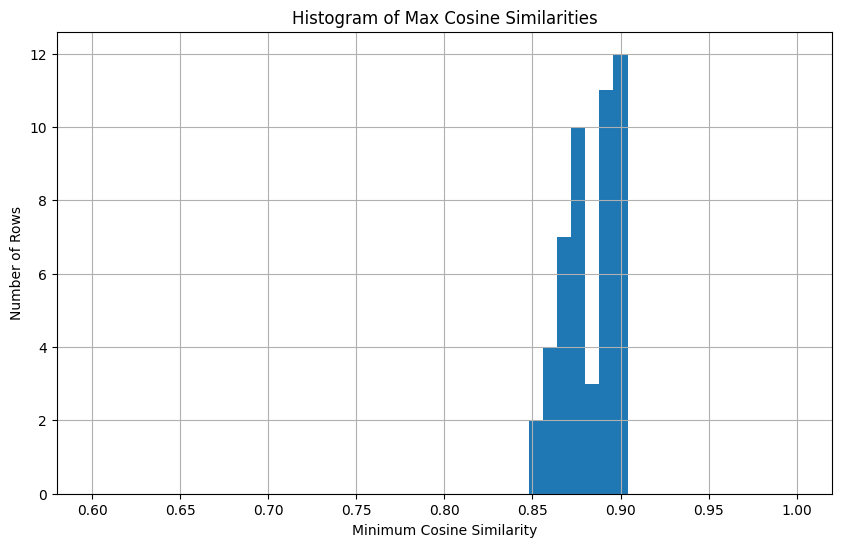

[0.871574175343106, 0.8993917175819024, 0.8993917175819024, 0.8992325308040114, 0.8750433652353392, 0.8911262218355431, 0.8868275056634473, 0.8916531776711177, 0.8605265300294493, 0.8798696193811036, 0.8707401981578616, 0.8707401981578616, 0.8996592612527635, 0.8934681833448923, 0.8977577399626503, 0.8938792504854862, 0.89496533849769, 0.8799779555535845, 0.8799779555535845, 0.8911262218355431, 0.8985388008777297, 0.8907499124668521, 0.897081758305172, 0.8575736221390687, 0.8977577399626503, 0.8682424022703153, 0.8996592612527635, 0.8907499124668521, 0.8750433652353392, 0.897081758305172, 0.8747112723202254, 0.8903859483767715, 0.8903859483767715, 0.8747112723202254, 0.8569930215584088, 0.8639007070742665, 0.8965289431936377, 0.8644929911797683, 0.887901546456129, 0.8555884666399585, 0.8985388008777297, 0.8786776645042517, 0.8786776645042517, 0.870468966760049, 0.852098083791921, 0.871574175343106, 0.887901546456129, 0.8934681833448923, 0.8794197939995553]


In [13]:
import matplotlib.pyplot as plt
import numpy as np
from vector_filter import create_similarity_matrix

embeddings = precompute_embeddings(df, 'Question')
similarity_matrix = create_similarity_matrix(embeddings)

num_rows = similarity_matrix.shape[0]

# Compute minimum similarities for each row, excluding self-similarity
max_similarities = [np.max(np.delete(row, i)) for i, row in enumerate(similarity_matrix)]

plt.figure(figsize=(10, 6))
plt.hist(max_similarities, bins=50, range=(0.6, 1))
plt.title('Histogram of Max Cosine Similarities')
plt.xlabel('Minimum Cosine Similarity')
plt.ylabel('Number of Rows')
plt.grid(True)
plt.show()

print(max_similarities)

## TF-IDF filtering

In [14]:
from stem import stem_sentence

def load_tfidf_matrix(csv_file):
    """Load the TF-IDF matrix from a CSV file."""
    tfidf_matrix = pd.read_csv(csv_file, index_col=0)
    tfidf_matrix.index = tfidf_matrix.index.str.strip()
    tfidf_matrix.columns = tfidf_matrix.columns.str.strip()
    tfidf_matrix.fillna(0, inplace=True)
    
    return tfidf_matrix

def sentence_to_tfidf(sentence, index, tfidf_matrix):
    index = index.strip()
    """Transform a sentence into a list of TF-IDF values."""
    tfidf_values = []
    stemmed_sentence = stem_sentence(sentence)
    
    for word in stemmed_sentence.split():
        # Check if the word is in the TF-IDF matrix
        if word in tfidf_matrix.columns:
            # Assuming 'filename' is the index of the row in tfidf_matrix
            tfidf_value = tfidf_matrix.at[index, word]
            tfidf_values.append(tfidf_value)
            #print(f"Found: {index, word}")
        else:
            # If the word is not in the matrix, append a value of 0
            tfidf_values.append(0)
            is_in_index = index in tfidf_matrix.index
            is_in_columns = word in tfidf_matrix.columns

            #print(f"Not found: {index, word}")
            #print(f"Item in index: {is_in_index}")
            #print(f"Column in DataFrame: {is_in_columns}")
            
    return tfidf_values;


tfidf_matrix = load_tfidf_matrix('tfidf_matrix_with_titles.csv')
tfidf_matrix.head()



[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package alpino to /home/jovyan/nltk_data...
[nltk_data]   Package alpino is already up-to-date!
/tmp/ipykernel_5652/461660353.py:5: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  tfidf_matrix = pd.read_csv(csv_file, index_col=0)


,Document,Stemmed_Doc,00,000,0029775,00uur,01,010,02,0200,...,约一名私人口译员,而正确实施对您的治疗,译员,话给他,请明确地说明您可以流利地使用哪种语言,这一点对您来说也至关重要,非常重要的,预约一位口译员,预约口译员,ꞌs
(Langdurig) gebroken vliezen,{'(Langdurig) gebroken vliezen': 'Als de vliez...,langdur gebrok vliez als vliez gebrok zwangers...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aambeien (heamorroiden),{'Aambeien': '(heamorroiden) Deze folder geeft...,aambei heamorroid dez folder geeft global over...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aangezichtsverlamming,{'Aangezichtsverlamming': 'Deze folder heeft t...,aangezichtsverlamm dez folder doel informatie ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aangifte van geboorte,{'Aangifte geboorte': 'Binnen 3 dagen geeft u ...,aangift geboort binn 3 dag geeft geboort baby ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aanvraagformulier kopie medische gegevens,{'Aanvraagformulier kopie medische gegevens': ...,aanvraagformulier kopie medisch gegeven let le...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
import pandas as pd


df['TF-IDF'] = df.apply(lambda row: sentence_to_tfidf(row["Question"], row["filename"], tfidf_matrix), axis=1)

# Create the 'Max TF-IDF' column by finding the max of each list in 'TF-IDF Temp'
df['Max TF-IDF'] = df['TF-IDF'].apply(max)
df.head()


,filename,header,section_text,Document,Question,Answer,Question-Context BLEU,Answer-Context BLEU,Question-Context ROUGE,Answer-Context ROUGE,Question-Context ROUGE-L F1,Answer-Context ROUGE-L F1,Embedding,TF-IDF,Max TF-IDF
0,"MFR, dynamische scan op de D-SPECT, 1 daags",Vragen,Hebt u na het lezen van deze informatie nog vr...,"MFR, dynamische scan op de D-SPECT, 1 daags: V...",Waar kan ik terecht met vragen over het MFR on...,U kunt bellen met de afdeling nucleaire genees...,2.160402e-233,4.264035e-02,"[{'rouge-1': {'r': 0.046511627906976744, 'p': ...","[{'rouge-1': {'r': 0.3023255813953488, 'p': 0....",0.075472,0.456140,"[-0.0013287522708734587, -0.023150097773017415...","[0.0, 0.0, 0, 0.0, 0.0]",0.0
1,"MFR, dynamische scan op de D-SPECT, 1 daags",Vragen,Hebt u na het lezen van deze informatie nog vr...,"MFR, dynamische scan op de D-SPECT, 1 daags: V...",Welk routenummer moet ik volgen om naar de afd...,U kunt routenummer 1.15 volgen om de afdeling ...,8.713939e-03,1.505700e-156,"[{'rouge-1': {'r': 0.09302325581395349, 'p': 0...","[{'rouge-1': {'r': 0.13953488372093023, 'p': 0...",0.142857,0.222222,"[0.008824661700584999, -0.020310531190463776, ...","[0.0, 0.0, 0.0, 0, 0.0, 0, 0]",0.0
3,"MFR, dynamische scan op de D-SPECT, 1 daags",Vragen,Hebt u na het lezen van deze informatie nog vr...,"MFR, dynamische scan op de D-SPECT, 1 daags: V...",Welke ziekenhuislocatie is de afdeling nucleai...,De afdeling nucleaire geneeskunde is gevestigd...,1.523694e-03,5.866322e-80,"[{'rouge-1': {'r': 0.09302325581395349, 'p': 0...","[{'rouge-1': {'r': 0.11627906976744186, 'p': 0...",0.156863,0.192308,"[0.01560889362991692, -0.02402423124011381, 0....","[0.0, 0.0, 0, 0.0, 0, 0.0]",0.0
5,Borstoperatie met prothese,Vragen,Heeft u naar aanleiding van deze folder vragen...,Borstoperatie met prothese: Vragen: Heeft u na...,Wat is het telefoonnummer van het ZGT secretar...,Het telefoonnummer van het ZGT secretariaat pl...,1.292739e-02,5.493551e-02,"[{'rouge-1': {'r': 0.1388888888888889, 'p': 0....","[{'rouge-1': {'r': 0.25, 'p': 0.69230769230769...",0.222222,0.367347,"[-0.005797730502929354, -0.01354075179075594, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0
8,Borstoperatie met prothese,Vragen,Heeft u naar aanleiding van deze folder vragen...,Borstoperatie met prothese: Vragen: Heeft u na...,Waar kunt u terecht met vragen over borstopera...,U kunt terecht bij het ZGT secretariaat plasti...,7.043552e-233,3.060034e-02,"[{'rouge-1': {'r': 0.05555555555555555, 'p': 0...","[{'rouge-1': {'r': 0.1111111111111111, 'p': 0....",0.088889,0.156863,"[-0.009808297636767578, -0.025408646494440336,...","[0.0, 0.0, 0.0, 0, 0.0, 0.0]",0.0


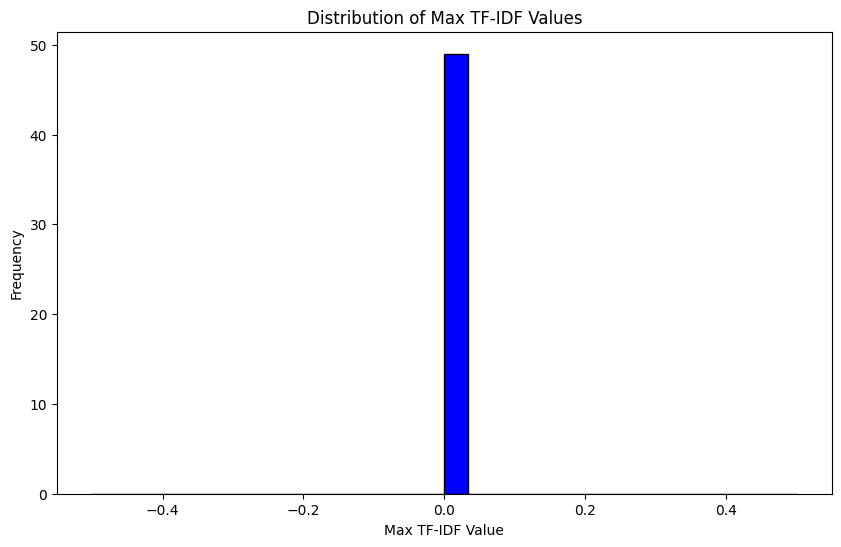

In [16]:
import matplotlib.pyplot as plt

# Plot the distribution of the Max TF-IDF column
plt.figure(figsize=(10, 6))
plt.hist(df['Max TF-IDF'], bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Max TF-IDF Values')
plt.xlabel('Max TF-IDF Value')
plt.ylabel('Frequency')
plt.show()

## Entity Filter

In [18]:
from extract import extract_all_entities

df['Context Entities'] = df['Document'].apply(extract_all_entities)
df['Question Entities'] = df['Question'].apply(extract_all_entities)
df['Answer Entities'] = df['Answer'].apply(extract_all_entities)

df.head()

/home/jovyan/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
2024-01-17 13:35:35.521129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-17 13:35:35.668294: I tensorflow/core/util/port.cc:104] oneDNN custom operations are 

2024-01-17 13:35:51,323 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-PER, S-LOC, B-MISC, E-MISC, B-ORG, E-ORG, I-ORG, I-PER, B-LOC, I-LOC, E-LOC, I-MISC, <START>, <STOP>


,filename,header,section_text,Document,Question,Answer,Question-Context BLEU,Answer-Context BLEU,Question-Context ROUGE,Answer-Context ROUGE,Question-Context ROUGE-L F1,Answer-Context ROUGE-L F1,Embedding,TF-IDF,Max TF-IDF,Context Entities,Question Entities,Answer Entities
0,"MFR, dynamische scan op de D-SPECT, 1 daags",Vragen,Hebt u na het lezen van deze informatie nog vr...,"MFR, dynamische scan op de D-SPECT, 1 daags: V...",Waar kan ik terecht met vragen over het MFR on...,U kunt bellen met de afdeling nucleaire genees...,2.160402e-233,4.264035e-02,"[{'rouge-1': {'r': 0.046511627906976744, 'p': ...","[{'rouge-1': {'r': 0.3023255813953488, 'p': 0....",0.075472,0.456140,"[-0.0013287522708734587, -0.023150097773017415...","[0.0, 0.0, 0, 0.0, 0.0]",0.0,"[{'entityType': 'Phone', 'value': '+3188708567...","[{'entityType': 'MISC', 'value': 'MFR'}]","[{'entityType': 'Phone', 'value': '+3188708567..."
1,"MFR, dynamische scan op de D-SPECT, 1 daags",Vragen,Hebt u na het lezen van deze informatie nog vr...,"MFR, dynamische scan op de D-SPECT, 1 daags: V...",Welk routenummer moet ik volgen om naar de afd...,U kunt routenummer 1.15 volgen om de afdeling ...,8.713939e-03,1.505700e-156,"[{'rouge-1': {'r': 0.09302325581395349, 'p': 0...","[{'rouge-1': {'r': 0.13953488372093023, 'p': 0...",0.142857,0.222222,"[0.008824661700584999, -0.020310531190463776, ...","[0.0, 0.0, 0.0, 0, 0.0, 0, 0]",0.0,"[{'entityType': 'Phone', 'value': '+3188708567...",[],[]
3,"MFR, dynamische scan op de D-SPECT, 1 daags",Vragen,Hebt u na het lezen van deze informatie nog vr...,"MFR, dynamische scan op de D-SPECT, 1 daags: V...",Welke ziekenhuislocatie is de afdeling nucleai...,De afdeling nucleaire geneeskunde is gevestigd...,1.523694e-03,5.866322e-80,"[{'rouge-1': {'r': 0.09302325581395349, 'p': 0...","[{'rouge-1': {'r': 0.11627906976744186, 'p': 0...",0.156863,0.192308,"[0.01560889362991692, -0.02402423124011381, 0....","[0.0, 0.0, 0, 0.0, 0, 0.0]",0.0,"[{'entityType': 'Phone', 'value': '+3188708567...",[],"[{'entityType': 'LOC', 'value': 'Hengelo'}]"
5,Borstoperatie met prothese,Vragen,Heeft u naar aanleiding van deze folder vragen...,Borstoperatie met prothese: Vragen: Heeft u na...,Wat is het telefoonnummer van het ZGT secretar...,Het telefoonnummer van het ZGT secretariaat pl...,1.292739e-02,5.493551e-02,"[{'rouge-1': {'r': 0.1388888888888889, 'p': 0....","[{'rouge-1': {'r': 0.25, 'p': 0.69230769230769...",0.222222,0.367347,"[-0.005797730502929354, -0.01354075179075594, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,"[{'entityType': 'Phone', 'value': '+3188708524...","[{'entityType': 'ORG', 'value': 'ZGT'}]","[{'entityType': 'Phone', 'value': '+3188708524..."
8,Borstoperatie met prothese,Vragen,Heeft u naar aanleiding van deze folder vragen...,Borstoperatie met prothese: Vragen: Heeft u na...,Waar kunt u terecht met vragen over borstopera...,U kunt terecht bij het ZGT secretariaat plasti...,7.043552e-233,3.060034e-02,"[{'rouge-1': {'r': 0.05555555555555555, 'p': 0...","[{'rouge-1': {'r': 0.1111111111111111, 'p': 0....",0.088889,0.156863,"[-0.009808297636767578, -0.025408646494440336,...","[0.0, 0.0, 0.0, 0, 0.0, 0.0]",0.0,"[{'entityType': 'Phone', 'value': '+3188708524...",[],"[{'entityType': 'ORG', 'value': 'ZGT'}]"


In [19]:
def contains_all_elements(list1, list2):
    """
    Check if list1 contains all elements of list2.
    Each element is a dictionary with 'entityType' and 'value' keys.
    """
    # Convert each dictionary in the lists to a tuple (entityType, value) for easy comparison
    set1 = {d['value'] for d in list1 if 'value' in d}
    set2 = {d['value'] for d in list2 if 'value' in d}

    # Check if every element in set2 is also in set1
    return set2.issubset(set1)

def check_entity_match(row):
    return contains_all_elements(row['Context Entities'], row['Answer Entities'])

# Apply the function to each row to create the new column
df['Entity Match'] = df.apply(check_entity_match, axis=1)


In [20]:
df.head()

,filename,header,section_text,Document,Question,Answer,Question-Context BLEU,Answer-Context BLEU,Question-Context ROUGE,Answer-Context ROUGE,Question-Context ROUGE-L F1,Answer-Context ROUGE-L F1,Embedding,TF-IDF,Max TF-IDF,Context Entities,Question Entities,Answer Entities,Entity Match
0,"MFR, dynamische scan op de D-SPECT, 1 daags",Vragen,Hebt u na het lezen van deze informatie nog vr...,"MFR, dynamische scan op de D-SPECT, 1 daags: V...",Waar kan ik terecht met vragen over het MFR on...,U kunt bellen met de afdeling nucleaire genees...,2.160402e-233,4.264035e-02,"[{'rouge-1': {'r': 0.046511627906976744, 'p': ...","[{'rouge-1': {'r': 0.3023255813953488, 'p': 0....",0.075472,0.456140,"[-0.0013287522708734587, -0.023150097773017415...","[0.0, 0.0, 0, 0.0, 0.0]",0.0,"[{'entityType': 'Phone', 'value': '+3188708567...","[{'entityType': 'MISC', 'value': 'MFR'}]","[{'entityType': 'Phone', 'value': '+3188708567...",True
1,"MFR, dynamische scan op de D-SPECT, 1 daags",Vragen,Hebt u na het lezen van deze informatie nog vr...,"MFR, dynamische scan op de D-SPECT, 1 daags: V...",Welk routenummer moet ik volgen om naar de afd...,U kunt routenummer 1.15 volgen om de afdeling ...,8.713939e-03,1.505700e-156,"[{'rouge-1': {'r': 0.09302325581395349, 'p': 0...","[{'rouge-1': {'r': 0.13953488372093023, 'p': 0...",0.142857,0.222222,"[0.008824661700584999, -0.020310531190463776, ...","[0.0, 0.0, 0.0, 0, 0.0, 0, 0]",0.0,"[{'entityType': 'Phone', 'value': '+3188708567...",[],[],True
3,"MFR, dynamische scan op de D-SPECT, 1 daags",Vragen,Hebt u na het lezen van deze informatie nog vr...,"MFR, dynamische scan op de D-SPECT, 1 daags: V...",Welke ziekenhuislocatie is de afdeling nucleai...,De afdeling nucleaire geneeskunde is gevestigd...,1.523694e-03,5.866322e-80,"[{'rouge-1': {'r': 0.09302325581395349, 'p': 0...","[{'rouge-1': {'r': 0.11627906976744186, 'p': 0...",0.156863,0.192308,"[0.01560889362991692, -0.02402423124011381, 0....","[0.0, 0.0, 0, 0.0, 0, 0.0]",0.0,"[{'entityType': 'Phone', 'value': '+3188708567...",[],"[{'entityType': 'LOC', 'value': 'Hengelo'}]",True
5,Borstoperatie met prothese,Vragen,Heeft u naar aanleiding van deze folder vragen...,Borstoperatie met prothese: Vragen: Heeft u na...,Wat is het telefoonnummer van het ZGT secretar...,Het telefoonnummer van het ZGT secretariaat pl...,1.292739e-02,5.493551e-02,"[{'rouge-1': {'r': 0.1388888888888889, 'p': 0....","[{'rouge-1': {'r': 0.25, 'p': 0.69230769230769...",0.222222,0.367347,"[-0.005797730502929354, -0.01354075179075594, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,"[{'entityType': 'Phone', 'value': '+3188708524...","[{'entityType': 'ORG', 'value': 'ZGT'}]","[{'entityType': 'Phone', 'value': '+3188708524...",True
8,Borstoperatie met prothese,Vragen,Heeft u naar aanleiding van deze folder vragen...,Borstoperatie met prothese: Vragen: Heeft u na...,Waar kunt u terecht met vragen over borstopera...,U kunt terecht bij het ZGT secretariaat plasti...,7.043552e-233,3.060034e-02,"[{'rouge-1': {'r': 0.05555555555555555, 'p': 0...","[{'rouge-1': {'r': 0.1111111111111111, 'p': 0....",0.088889,0.156863,"[-0.009808297636767578, -0.025408646494440336,...","[0.0, 0.0, 0.0, 0, 0.0, 0.0]",0.0,"[{'entityType': 'Phone', 'value': '+3188708524...",[],"[{'entityType': 'ORG', 'value': 'ZGT'}]",True


In [21]:
df.to_csv(f"./tmp_{fname}.csv")

#### LLM Scoring

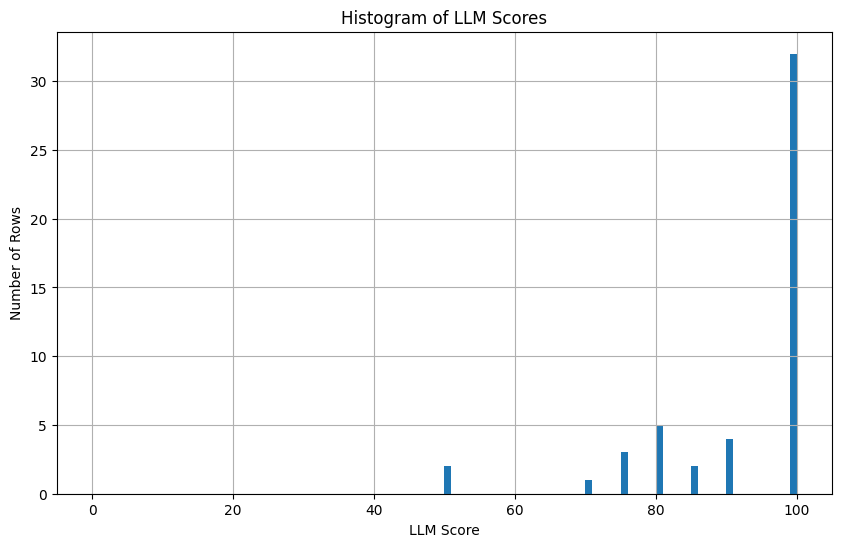

In [26]:
from llm_filter import estimate_relevance

df['LLM Score'] = df.apply(lambda row: estimate_relevance(row['Question'], row['Document']), axis=1).

plt.figure(figsize=(10, 6))
plt.hist(df['LLM Score'], bins=100, range=(0, 100))
plt.title('Histogram of LLM Scores')
plt.xlabel('LLM Score')
plt.ylabel('Number of Rows')
plt.grid(True)
plt.show()

## Export Q&A Pairs

In [27]:
df.to_csv(f"./output_{fname}.csv")

In [ ]:
df
